In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

df = pd.read_csv("data/f1_ml_laps_dataset.csv")
print("Raw shape:", df.shape)

# Clean
df = df[(df["lap_time"] > 30) & (df["lap_time"] < 200)]
df = df.dropna(subset=["sector_1_time", "sector_2_time", "sector_3_time"])

df.head()



Raw shape: (23983, 31)


,season,gp_name,session_name,session_type,driver,team,lap_number,lap_time,sector_1_time,sector_2_time,sector_3_time,position,track_status,is_pit_lap,compound,stint,tyre_life,fresh_tyre,speed_mean,speed_max,throttle_mean,brake_mean,rpm_mean,rpm_max,drs_activations,air_temp,track_temp,humidity,wind_speed,wind_dir,pressure
1,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,2,97.974,31.342,42.504,24.128,1,12,False,SOFT,1,5,False,195.407713,298,60.225895,0.203857,9773.179063,12063,363,27.3,31.1,22,0.0,208,1016.7
2,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,3,98.006,31.388,42.469,24.149,1,1,False,SOFT,1,6,False,198.095109,298,62.290761,0.184783,9756.970109,11795,0,27.3,31.2,22,0.6,170,1016.7
3,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,4,97.976,31.271,42.642,24.063,1,1,False,SOFT,1,7,False,195.786842,299,62.092105,0.200000,9723.621053,11960,0,27.2,31.1,22,0.8,236,1016.9
4,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,5,98.035,31.244,42.724,24.067,1,1,False,SOFT,1,8,False,197.120879,301,60.884615,0.206044,9710.263736,11911,0,27.2,31.0,22,1.0,206,1016.7
5,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,6,97.986,31.341,42.632,24.013,1,1,False,SOFT,1,9,False,196.887363,301,60.942308,0.200549,9767.299451,11852,0,27.1,31.0,22,0.6,175,1016.9


In [27]:
tyre_base = df.copy()

if "is_pit_lap" in tyre_base.columns:
    tyre_base = tyre_base[tyre_base["is_pit_lap"] == 0]

if "track_status" in tyre_base.columns:
    tyre_base = tyre_base[tyre_base["track_status"] == 1]

driver_means = tyre_base.groupby("driver")["lap_time"].mean()
global_mean = tyre_base["lap_time"].mean()
driver_offset_map = (driver_means - global_mean).to_dict()

tyre_base["driver_pace_offset"] = tyre_base["driver"].map(driver_offset_map)
tyre_base["driver_pace_offset"] -= tyre_base["driver_pace_offset"].mean()

# Adding fuel load
# Lap 1 = 100% fuel, Last lap = 0% fuel
tyre_base['fuel_load_pct'] = 1 - (
    tyre_base['lap_number'] / 
    tyre_base.groupby('gp_name')['lap_number'].transform('max')
)

print(f"✅ Added fuel_load_pct feature")
print(f"   Lap 1 fuel: {tyre_base['fuel_load_pct'].max():.2f} (100%)")
print(f"   Last lap fuel: {tyre_base['fuel_load_pct'].min():.2f} (0%)")


✅ Added fuel_load_pct feature
   Lap 1 fuel: 0.97 (100%)
   Last lap fuel: 0.00 (0%)


In [28]:
tyre_cat_features = ["gp_name", "compound"]
tyre_base['fuel_load_pct'] = 1 - (tyre_base['lap_number'] / tyre_base.groupby('gp_name')['lap_number'].transform('max'))


tyre_num_features = [
    "tyre_life", "stint",
    "fuel_load_pct",
    "track_temp", "air_temp", "humidity",
    "wind_speed", "wind_dir", "pressure",
    "driver_pace_offset"
]

tyre_target = "lap_time"

cols_needed = tyre_cat_features + tyre_num_features + [tyre_target]

tyre_df = tyre_base.dropna(subset=cols_needed).copy()
print("Tyre dataset:", tyre_df.shape)

Tyre dataset: (20541, 50)


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

X_t = tyre_df[tyre_cat_features + tyre_num_features]
y_t = tyre_df[tyre_target]

X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(
    X_t, y_t, test_size=0.2, random_state=42
)

num_t = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_t = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

pre_tyre = ColumnTransformer([
    ("num", num_t, tyre_num_features),
    ("cat", cat_t, tyre_cat_features)
])

tyre_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

tyre_pipeline = Pipeline([
    ("pre", pre_tyre),
    ("model", tyre_model)
])

print("Training RandomForest model...")
tyre_pipeline.fit(X_t_train, y_t_train)

y_t_pred = tyre_pipeline.predict(X_t_test)

print(f"\n Model: RandomForest with {tyre_model.n_estimators} trees")

Training RandomForest model...

 Model: RandomForest with 300 trees


In [37]:
def get_driver_offset(driver_name):
    return float(driver_offset_map.get(driver_name, 0.0))

def predict_tyre_laptime(
    gp_name, compound, tyre_life, stint,
    fuel_load_pct,
    track_temp, air_temp, humidity,
    wind_speed, wind_dir, pressure,
    driver=None
):
    pace = get_driver_offset(driver) if driver else 0.0

    row = {
        "gp_name": gp_name,
        "compound": compound,
        "tyre_life": tyre_life,
        "stint": stint,
        "fuel_load_pct": fuel_load_pct,
        "track_temp": track_temp,
        "air_temp": air_temp,
        "humidity": humidity,
        "wind_speed": wind_speed,
        "wind_dir": wind_dir,
        "pressure": pressure,
        "driver_pace_offset": pace
    }

    return float(tyre_pipeline.predict(pd.DataFrame([row]))[0])


In [38]:
def estimate_pit_loss(df_full, gp_name, driver=None):
    temp = df_full[df_full["gp_name"] == gp_name]

    if driver:
        temp = temp[temp["driver"] == driver]

    if "is_pit_lap" not in temp.columns:
        return 20.0

    pit = temp[temp["is_pit_lap"] == 1]["lap_time"]
    normal = temp[temp["is_pit_lap"] == 0]["lap_time"]

    if pit.empty or normal.empty:
        return 20.0

    return float(np.clip(pit.median() - normal.median(), 10, 35))


In [39]:
def simulate_tyre_strategy(strategy, total_laps, pit_loss, gp_name, weather_dict, driver=None):
    laps = []
    total_time = 0
    lap_num = 1
    stint_idx = 0

    for compound, stint_len in strategy:
        stint_idx += 1
        for life in range(1, stint_len + 1):
            if lap_num > total_laps:
                break

            fuel_pct = 1 - (lap_num / total_laps)

            lt = predict_tyre_laptime(
                gp_name, compound, life, stint_idx,
                fuel_pct, 
                weather_dict["track_temp"], weather_dict["air_temp"],
                weather_dict["humidity"], weather_dict["wind_speed"],
                weather_dict["wind_dir"], weather_dict["pressure"],
                driver=driver
            )

            total_time += lt
            laps.append({"lap": lap_num, "compound": compound, "lap_time_pred": lt})
            lap_num += 1

        if lap_num <= total_laps:
            total_time += pit_loss

    return total_time, pd.DataFrame(laps)


In [40]:
def possible_stint_lengths(total_laps):
    return list(range(10, min(30, total_laps - 10) + 1))

def generate_strategies_fast(total_laps, compounds):
    lengths = possible_stint_lengths(total_laps)
    strategies = []

    # 1-stop (2 stints)
    for c1 in compounds:
        for c2 in compounds:
            if c1 == c2:
                continue

            for s1 in lengths:
                s2 = total_laps - s1
                if s2 < 10 or s2 > 30:
                    continue
                strategies.append([(c1, s1), (c2, s2)])

    # 2-stop (3 stints)
    for c1 in compounds:
        for c2 in compounds:
            for c3 in compounds:
                if len({c1, c2, c3}) < 2:
                    continue

                for s1 in lengths:
                    for s2 in lengths:
                        s3 = total_laps - (s1 + s2)
                        if 10 <= s3 <= 30:
                            strategies.append([(c1, s1), (c2, s2), (c3, s3)])

    return strategies


In [41]:
def find_best_strategies(
    gp_name, total_laps, weather_dict, driver=None, top_k=5
):
    compounds = sorted(df["compound"].unique())
    pit_loss = estimate_pit_loss(df, gp_name, driver)

    strategies = generate_strategies_fast(total_laps, compounds)

    results = []
    for strat in strategies:
        tt, _ = simulate_tyre_strategy(
            strat, total_laps, pit_loss, gp_name, weather_dict, driver,
        )
        results.append({"strategy": strat, "total_time": tt})

    return pd.DataFrame(results).sort_values("total_time").head(top_k)


In [44]:
from tqdm import tqdm

weather = {
    "track_temp": 36,
    "air_temp": 28,
    "humidity": 40,
    "wind_speed": 3.2,
    "wind_dir": 140,
    "pressure": 1006,
}

race_laps = 57  # Bahrain

# Only use DRY compounds
dry_compounds = ['HARD', 'MEDIUM', 'SOFT']
pit_loss = estimate_pit_loss(df, "Bahrain Grand Prix")

print(f"🔍 Searching tire strategies for Bahrain GP ({race_laps} laps)")
print(f"   Compounds: {dry_compounds}")
print(f"   Pit stop time: {pit_loss:.1f}s\n")

# Test limited strategies (1-stop only, key stint lengths)
strategies_to_test = []
for c1 in dry_compounds:
    for c2 in dry_compounds:
        if c1 == c2:
            continue
        for s1 in [20, 25, 27, 30, 32]:
            s2 = race_laps - s1
            if 20 <= s2 <= 37:
                strategies_to_test.append([(c1, s1), (c2, s2)])

print(f"Testing {len(strategies_to_test)} strategies...\n")

results = []
for strat in tqdm(strategies_to_test, desc="Simulating"):
    tt, _ = simulate_tyre_strategy(
        strat, race_laps, pit_loss, "Bahrain Grand Prix", weather, driver=None
    )
    results.append({"strategy": str(strat), "total_time": tt})

best = pd.DataFrame(results).sort_values("total_time").head(10)

print(f"\n Top 10 Tire Strategies for Bahrain:\n")
best

🔍 Searching tire strategies for Bahrain GP (57 laps)
   Compounds: ['HARD', 'MEDIUM', 'SOFT']
   Pit stop time: 19.2s

Testing 30 strategies...



Simulating: 100%|██████████| 30/30 [00:49<00:00,  1.64s/it]


 Top 10 Tire Strategies for Bahrain:



,strategy,total_time
19,"[('MEDIUM', 32), ('SOFT', 25)]",5436.048336
18,"[('MEDIUM', 30), ('SOFT', 27)]",5436.527447
17,"[('MEDIUM', 27), ('SOFT', 30)]",5436.577510
16,"[('MEDIUM', 25), ('SOFT', 32)]",5436.878362
15,"[('MEDIUM', 20), ('SOFT', 37)]",5436.945937
14,"[('MEDIUM', 32), ('HARD', 25)]",5437.400618
9,"[('HARD', 32), ('SOFT', 25)]",5437.597354
13,"[('MEDIUM', 30), ('HARD', 27)]",5437.973580
8,"[('HARD', 30), ('SOFT', 27)]",5438.021716
7,"[('HARD', 27), ('SOFT', 30)]",5438.045268


MODEL PREDICTIONS: Tire Degradation (After adding Fuel Load) 

SOFT:
  Lap 1:  94.23s
  Lap 40: 95.37s
  Total degradation: +1.14s
  Degradation per lap: +0.028s/lap

MEDIUM:
  Lap 1:  94.18s
  Lap 40: 95.43s
  Total degradation: +1.25s
  Degradation per lap: +0.031s/lap

HARD:
  Lap 1:  94.18s
  Lap 40: 95.44s
  Total degradation: +1.26s
  Degradation per lap: +0.031s/lap



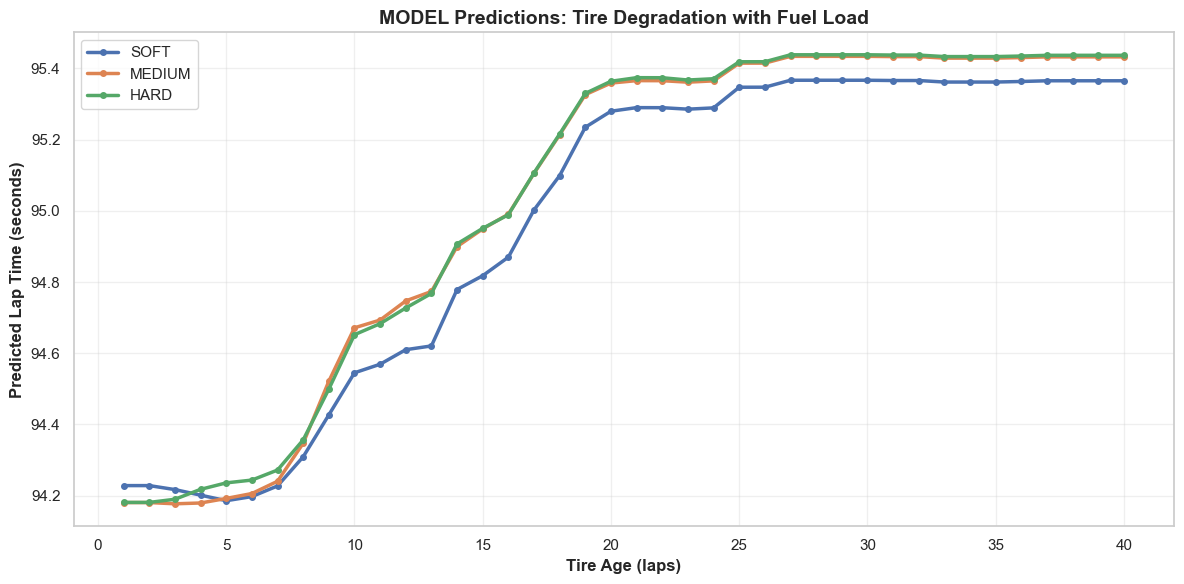

In [43]:
import matplotlib.pyplot as plt
print("MODEL PREDICTIONS: Tire Degradation (After adding Fuel Load) \n")

fig, ax = plt.subplots(figsize=(12, 6))

# Simulating tire degradation for each compound
tire_ages = range(1, 41)

for compound in ['SOFT', 'MEDIUM', 'HARD']:
    predicted_times = []
    
    for age in tire_ages:
        pred = predict_tyre_laptime(
            gp_name="Bahrain Grand Prix",
            compound=compound,
            tyre_life=age,
            stint=1,
            fuel_load_pct=0.5,
            track_temp=36,
            air_temp=28,
            humidity=40,
            wind_speed=3.2,
            wind_dir=140,
            pressure=1006,
            driver=None
        )
        predicted_times.append(pred)
    
    ax.plot(tire_ages, predicted_times, marker='o', label=compound, 
            linewidth=2.5, markersize=4)
    
    # Degradation rate
    degradation_total = predicted_times[-1] - predicted_times[0]
    degradation_rate = degradation_total / len(tire_ages)
    
    print(f"{compound}:")
    print(f"  Lap 1:  {predicted_times[0]:.2f}s")
    print(f"  Lap 40: {predicted_times[-1]:.2f}s")
    print(f"  Total degradation: {degradation_total:+.2f}s")
    print(f"  Degradation per lap: {degradation_rate:+.3f}s/lap")
    print()

ax.set_xlabel('Tire Age (laps)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Lap Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('MODEL Predictions: Tire Degradation with Fuel Load', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()